In [1]:
import os
import sys
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import math
import glob
import keras
import sklearn
import librosa
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
AUDIO_EXTENSIONS = [".wav", ".mp3", ".flac", ".ogg", ".aiff"]
DATASET_DIR = '/workspace/kuba-dataset'
SAMPLE_RATE, SAMPLE_SECONDS = 48000, 4
BATCH_SIZE = 8

In [3]:
@keras.saving.register_keras_serializable()
class SlaneyNormalization(keras.layers.Layer):
    """
    Match librosa's Slaney filter-bank normalisation.
    Pass the number of mel bins created by MelSpectrogram.
    """
    def __init__(self, num_mel_bins, **kwargs):
        super().__init__(**kwargs)
        # Pre-compute 2 / (high-freq – low-freq) factor used by librosa
        self.scale = self.add_weight(
            name="slaney_norm",
            shape=(num_mel_bins, 1),   # one factor per mel filter
            initializer=tf.keras.initializers.Constant(2.0),  # librosa constant
            trainable=False,
        )

    def call(self, S):
        # S has shape [batch, freq, time]
        return S * self.scale   # broadcast along batch & time

@keras.saving.register_keras_serializable()
class PowerToDB(keras.layers.Layer):
    """
    Convert power/amplitude spectrogram to dB exactly like
    librosa.power_to_db(S, ref=np.max, top_db=80).
    Works on [batch, freq, time] tensors.
    """
    def __init__(self, amin=1e-10, top_db=80.0, **kwargs):
        super().__init__(**kwargs)
        self.amin   = tf.constant(amin, dtype=tf.float32)
        self.top_db = tf.constant(top_db, dtype=tf.float32)

    def call(self, S):
        S = tf.maximum(S, self.amin)
        # 10*log10(S)
        log_spec = 10.0 * tf.math.log(S) / tf.math.log(tf.constant(10.0))
        # subtract per-example max → 0 dB peak
        max_per_example = tf.reduce_max(log_spec, axis=[1, 2], keepdims=True)
        log_spec = log_spec - max_per_example
        # apply top-dB floor
        log_spec = tf.maximum(log_spec, -self.top_db)
        return log_spec

@keras.saving.register_keras_serializable()
class SpectralNoiseReducer(keras.layers.Layer):
    """Reduces background noise from spectrograms using spectral subtraction with smoothing.
    
    This layer estimates noise profile from low-energy frames and subtracts it from
    the spectrogram with optional smoothing and masking.
    """
    def __init__(self, 
                 noise_frame_count=10,  # Number of frames to use for noise profile
                 reduction_factor=1.5,  # How aggressively to reduce noise
                 smoothing=0.2,         # Time smoothing factor (0-1)
                 min_gain_db=-15.0,     # Minimum allowed reduction in dB 
                 freq_axis=1,           # Spectrogram frequency axis
                 time_axis=2,           # Spectrogram time axis
                 epsilon=1e-10,         # Small value to prevent division by zero
                 **kwargs):
        super().__init__(**kwargs)
        self.noise_frame_count = noise_frame_count
        self.reduction_factor = reduction_factor
        self.smoothing = smoothing
        self.min_gain_db = min_gain_db
        self.freq_axis = freq_axis
        self.time_axis = time_axis
        self.epsilon = epsilon
        self.noise_profile = None
    
    def build(self, input_shape):
        # Initialize noise profile tensor
        self.noise_profile = self.add_weight(
            name="noise_profile",
            shape=(input_shape[self.freq_axis],),
            initializer="zeros",
            trainable=False,
        )
        super().build(input_shape)
    
    def call(self, inputs, training=None):
        # Calculate frame energy across frequency bins
        frame_energy = tf.reduce_mean(inputs, axis=self.freq_axis)
        
        # Find the indices of the lowest-energy frames
        _, indices = tf.nn.top_k(-frame_energy, k=self.noise_frame_count)
        
        # Estimate noise profile from the lowest energy frames
        noise_frames = tf.gather(inputs, indices, axis=self.time_axis)
        estimated_noise = tf.reduce_mean(noise_frames, axis=self.time_axis)
        
        # Update noise profile with smoothing
        if training:
            # Only update noise profile during training
            self.noise_profile.assign(
                self.noise_profile * (1 - self.smoothing) + 
                estimated_noise * self.smoothing
            )
        
        # Apply spectral subtraction with flooring
        # Fix: Reshape noise_profile to match input dimensions properly
        noise_profile_adjusted = self.noise_profile * self.reduction_factor
        
        # Add necessary dimensions to match the input shape
        # For input shape [batch, freq, time], we need to add a time dimension
        noise_adjusted = tf.reshape(
            noise_profile_adjusted,
            [1, tf.shape(noise_profile_adjusted)[0], 1]
        )
        
        # Ensure we don't reduce by more than min_gain_db
        min_gain = tf.pow(10.0, self.min_gain_db / 10.0)
        gain = tf.maximum(
            (inputs - noise_adjusted) / (inputs + self.epsilon),
            min_gain
        )
        
        # Apply the gain to the input spectrogram
        return inputs * gain
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "noise_frame_count": self.noise_frame_count,
            "reduction_factor": self.reduction_factor,
            "smoothing": self.smoothing,
            "min_gain_db": self.min_gain_db,
            "freq_axis": self.freq_axis,
            "time_axis": self.time_axis,
            "epsilon": self.epsilon,
        })
        return config

@keras.saving.register_keras_serializable()
class SpectrogramNoiseReducer(tf.keras.layers.Layer):
    """
    Differentiable noise-reduction layer for magnitude spectrograms.

    Args
    ----
    n_std_thresh:     # ×σ added to the noise floor to build the threshold
    noise_frames:     # how many initial time frames are treated as “pure noise”
    smoothing_bins:   # vertical smoothing of the binary mask (freq axis)
    smoothing_frames: # horizontal smoothing of the binary mask (time axis)
    prop_decrease:    # 0 → no attenuation, 1 → full attenuation below threshold
    """

    def __init__(
        self,
        n_std_thresh: float = 1.5,
        noise_frames: int = 6,
        smoothing_bins: int = 3,
        smoothing_frames: int = 5,
        prop_decrease: float = 1.0,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.n_std_thresh = n_std_thresh
        self.noise_frames = noise_frames
        self.smoothing_bins = smoothing_bins
        self.smoothing_frames = smoothing_frames
        self.prop_decrease = prop_decrease

        # 2-D averaging kernel for mask smoothing (depth-wise conv2d)
        k = tf.ones(
            shape=(self.smoothing_bins, self.smoothing_frames, 1, 1),
            dtype=tf.float32,
        ) / float(self.smoothing_bins * self.smoothing_frames)
        self.kernel = tf.constant(k, dtype=tf.float32)

    def call(self, spec):  # spec shape: (B, F, T)
        spec = tf.convert_to_tensor(spec, dtype=self.compute_dtype)
        eps = tf.cast(1e-8, spec.dtype)

        # 1) Estimate noise statistics on the first `noise_frames`
        noise_patch = spec[:, :, : self.noise_frames]            # (B, F, noise_frames)
        noise_mean = tf.reduce_mean(noise_patch, axis=-1, keepdims=True)
        noise_std = tf.math.reduce_std(noise_patch, axis=-1, keepdims=True)
        thresh = noise_mean + self.n_std_thresh * noise_std      # (B, F, 1)

        # 2) Hard binary mask
        hard_mask = tf.cast(spec > thresh, spec.dtype)           # (B, F, T)

        # 3) Smooth mask with depth-wise 2-D conv
        mask4d = tf.expand_dims(tf.transpose(hard_mask, (0, 2, 1)), -1)  # (B, T, F, 1)
        smooth = tf.nn.depthwise_conv2d(mask4d, self.kernel, strides=[1, 1, 1, 1], padding="SAME")
        smooth = tf.transpose(tf.squeeze(smooth, -1), (0, 2, 1))         # back to (B, F, T)
        smooth = tf.clip_by_value(smooth, 0.0, 1.0)

        # 4) Continuous gain mask
        gain = 1.0 - self.prop_decrease * (1.0 - smooth)          # (B, F, T)

        # 5) Apply mask
        return spec * gain + eps

    # Make the layer serialisable
    def get_config(self):
        cfg = super().get_config()
        cfg.update(
            dict(
                n_std_thresh=self.n_std_thresh,
                noise_frames=self.noise_frames,
                smoothing_bins=self.smoothing_bins,
                smoothing_frames=self.smoothing_frames,
                prop_decrease=self.prop_decrease,
            )
        )
        return cfg

@keras.saving.register_keras_serializable()
class MelToMagma(tf.keras.layers.Layer):
    """
    Converts a Mel-spectrogram to an RGB image (magma) and flattens it.
    """

    def __init__(self,
                 num_colors: int = 256,
                 cmap_name: str = "magma",
                 **kwargs):
        super().__init__(**kwargs)

        # Build a colour-lookup table (LUT) once, on the Python side.
        # Shape: (num_colors, 3)  – RGB only, ignore alpha.
        cmap = plt.get_cmap(cmap_name, num_colors)
        lut_np = cmap(np.arange(num_colors))[:, :3].astype("float32")

        # Save as a constant Tensor so it lives on the graph / GPU.
        self.lut = tf.constant(lut_np)            # (256, 3)
        self.num_colors = num_colors
        self.cmap_name = cmap_name

    def call(self, inputs):
        """
        inputs: (B, T, F) or (B, T, F, 1)  – floating point magnitudes.
        returns: (B, T * F * 3)  – flattened RGB image vectors.
        """

        # Ensure shape (B, T, F)
        if inputs.shape.rank == 4 and inputs.shape[-1] == 1:
            x = tf.squeeze(inputs, axis=-1)       # (B, T, F)
        else:
            x = inputs                            # (B, T, F)

        # Per-example min-max normalisation to [0, 1].
        x_min = tf.reduce_min(x, axis=[1, 2], keepdims=True)
        x_max = tf.reduce_max(x, axis=[1, 2], keepdims=True)
        x_norm = (x - x_min) / (x_max - x_min + 1e-6)

        # Map to integer indices in [0, num_colors-1].
        idx = tf.cast(tf.round(x_norm * (self.num_colors - 1)), tf.int32)   # (B, T, F)

        # Look up RGB values; gather() broadcasts batch dims automatically.
        rgb = tf.gather(self.lut, idx)              # (B, T, F, 3)
        return rgb

    def get_config(self):
        cfg = super().get_config()
        cfg.update(
            dict(
                num_colors=self.num_colors,
                cmap_name=self.cmap_name,
            )
        )
        return cfg

In [4]:
def load_and_normalize_audio(file_path, target_sr=SAMPLE_RATE):
    """
    Load audio file in various formats and normalize it
    """
    try:
        audio, sr = librosa.load(file_path, sr=target_sr, mono=False)
        if audio.ndim > 1:
            if audio.shape[0] > 1 and np.any(audio[1]):
                audio = np.mean(audio, axis=0)
            else:
                audio = audio[0]

        audio = librosa.util.normalize(audio)
        return audio

    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None


def audio_generator(files, labels, class_names, shuffle):
    """Generator that yields audio chunks and labels on demand"""
    num_classes = len(class_names)
    indices = list(range(len(files)))

    if shuffle:
        np.random.shuffle(indices)

    for idx in indices:
        file_path: str = files[idx]
        label = labels[idx]

        # One-hot encode the label
        one_hot = np.zeros(num_classes)
        one_hot[label] = 1
        audio = load_and_normalize_audio(file_path)
        yield audio, one_hot


def compute_class_weights(labels, class_names):
    """
    Compute class weights inversely proportional to class frequencies
    """
    # Count samples per class
    class_counts = np.bincount(labels, minlength=len(class_names))

    # Calculate weights inversely proportional to counts
    total_samples = len(labels)
    class_weights = {}

    for i, count in enumerate(class_counts):
        if count > 0:
            # Formula: total_samples / (num_classes * samples_in_class)
            class_weights[i] = total_samples / (len(class_names) * count)

    print("Class weights:", class_weights)
    return class_weights


def load_data(directory, validation_split=0.3, batch_size=BATCH_SIZE, shuffle=True):
    """
    Create a TensorFlow dataset from audio files in directory
    """
    audio_files = []
    class_names = []
    labels = []

    subdirs = [f for f in os.listdir(directory) if os.path.isdir(os.path.join(directory, f))]
    class_names = sorted(subdirs)
    class_indices = {name: i for i, name in enumerate(class_names)}

    # For each class directory, find all audio files
    for subdir in subdirs:
        class_dir = os.path.join(directory, subdir)
        class_idx = class_indices[subdir]

        for ext in AUDIO_EXTENSIONS:
            pattern = os.path.join(class_dir, f"*{ext}")
            audio_paths = glob.glob(pattern)
            
            for path in audio_paths:
                audio_files.append(path)
                labels.append(class_idx)

    # Calculate class weights before splitting
    class_weights = compute_class_weights(labels, class_names)

    # Split into train and validation sets
    train_files, val_files, train_labels, val_labels = sklearn.model_selection.train_test_split(
        audio_files, labels, test_size=validation_split, stratify=labels, random_state=42
    )

    print(f"Found {len(audio_files)} audio files in {len(class_names)} classes")
    print(f"Training on {len(train_files)} files, validating on {len(val_files)} files")

    # Define output signature for the generator
    output_signature = (
        tf.TensorSpec(shape=(SAMPLE_RATE * SAMPLE_SECONDS,), dtype=tf.float32),
        tf.TensorSpec(shape=(len(class_names),), dtype=tf.float32)
    )

    # Create TensorFlow datasets using generators
    train_dataset = tf.data.Dataset.from_generator(
        lambda: audio_generator(train_files, train_labels, class_names, shuffle=shuffle),
        output_signature=output_signature
    )

    val_dataset = tf.data.Dataset.from_generator(
        lambda: audio_generator(val_files, val_labels, class_names, shuffle=False),
        output_signature=output_signature
    )

    # Apply batching and prefetching
    train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_dataset   = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    train_steps    = math.ceil(len(train_files) / batch_size)
    val_steps      = math.ceil(len(val_files)   / batch_size)
    return train_dataset, val_dataset, class_names, class_weights, train_steps, val_steps

In [5]:
ds_train, ds_validate, class_names, class_weights, train_steps, val_steps = load_data(DATASET_DIR)
num_classes = len(class_names)

Class weights: {0: np.float64(13.535714285714286), 1: np.float64(1.6919642857142858), 2: np.float64(8.613636363636363), 3: np.float64(1.857843137254902), 4: np.float64(1.857843137254902), 5: np.float64(15.791666666666666), 6: np.float64(0.1994736842105263), 7: np.float64(0.9381188118811881)}
Found 758 audio files in 8 classes
Training on 530 files, validating on 228 files


I0000 00:00:1761396015.632970   18303 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14297 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:04:00.0, compute capability: 8.6


In [6]:
def make_model():
    inp = keras.Input(shape=(SAMPLE_SECONDS * SAMPLE_RATE,))
    x = keras.layers.MelSpectrogram(
        min_freq=3500,
        max_freq=8500,
        num_mel_bins=128,
        # sequence_length=2048,
        # sequence_stride=256,
        fft_length=1024,
        sampling_rate=SAMPLE_RATE,
        power_to_db=True
    )(inp)
    # x = SlaneyNormalization(x.shape[1])(x)
    # x = PowerToDB()(x)
    x = MelToMagma()(x)
    x = keras.applications.ResNet152V2(
        include_top=False,
        weights="imagenet",
        pooling="avg"
    )(x)

    # x = SpectrogramNoiseReducer()(x)

    # x = keras.layers.Lambda(log_norm, name='log_norm')(x)
    # x = keras.layers.Lambda(magma_map_tf, name='magma_colormap')(x)
    # x = keras.layers.Lambda(lambda imgs: keras.applications.resnet50.preprocess_input(imgs * 255.0), name='resnet_preprocess')(x)
    
    # x = keras.layers.Reshape((*x.shape[1:], 1))(x)
    # x = keras.layers.Concatenate(axis=-1)([x, x, x])

    # x = keras.layers.Conv2D(32, (3,3), activation='relu')(x)
    # x = keras.layers.MaxPooling2D((2,2))(x)
    # x = keras.layers.Conv2D(64, (3,3), activation='relu')(x)
    # x = keras.layers.MaxPooling2D((2,2))(x)
    # x = keras.layers.Conv2D(128, (3,3), activation='relu')(x)
    # x = keras.layers.Flatten()(x)
    # # x = keras.layers.GlobalAveragePooling2D()(x)
    # x = keras.layers.Dense(256, activation='relu')(x)
    # x = keras.layers.Dropout(0.3)(x)
    # x = keras.layers.Dense(128, activation='relu')(x)
    # x = keras.layers.Dropout(0.3)(x)
    
    outp = keras.layers.Dense(len(class_names), activation='softmax')(x)
    return keras.Model(inputs=inp, outputs=outp)

In [7]:
model = make_model()

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 192000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mel_spectrogram                 │ (None, 128, 376)       │             0 │
│ (MelSpectrogram)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mel_to_magma (MelToMagma)       │ (None, 128, 376, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet152v2 (Functional)        │ (None, 2048)           │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │        16,392 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,348,040 (222.58 MB)

 Trainable params: 58,204,296 (222.03 MB)

 Non-trainable params: 143,744 (561.50 KB)

In [8]:
EPOCHS = 10

history = model.fit(
    ds_train,
    validation_data=ds_validate,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    # steps_per_epoch=train_steps,
    # validation_steps=val_steps,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            filepath='../../.tstdata/ckpt/zdenda-checkpoint.keras',
            monitor='val_accuracy',
            mode='max',
            save_best_only=True,
            save_freq="epoch"
        )
    ]    
)


Epoch 1/10


I0000 00:00:1761396173.602258   18461 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


     67/Unknown 214s 933ms/step - accuracy: 0.5465 - loss: 1.5002

/venv/main/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


67/67 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.5981 - loss: 1.2482 - val_accuracy: 0.1360 - val_loss: 772.4453
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - accuracy: 0.6736 - loss: 0.9762 - val_accuracy: 0.1272 - val_loss: 41.8487
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 14s 212ms/step - accuracy: 0.7264 - loss: 0.8705 - val_accuracy: 0.6667 - val_loss: 1.4696
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - accuracy: 0.7698 - loss: 0.6705 - val_accuracy: 0.6974 - val_loss: 1.4485
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 14s 213ms/step - accuracy: 0.8396 - loss: 0.5341 - val_accuracy: 0.7456 - val_loss: 1.0280
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - accuracy: 0.8755 - loss: 0.4335 - val_accuracy: 0.6009 - val_loss: 1.7236
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - accuracy: 0.8679 - loss: 0.4454 - val_accuracy: 0.7632 - val_loss: 1.0304
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 0.8868 - loss: 0.3907 - val_accuracy: 0.71

In [9]:
def plot_history(history):
    """
    Plots training and validation accuracy/loss curves from a Keras History object.
    """
    # Extract training metrics
    acc = history.history.get('accuracy')
    val_acc = history.history.get('val_accuracy')
    loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')

    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    if val_acc:
        plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')

    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    if val_loss:
        plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

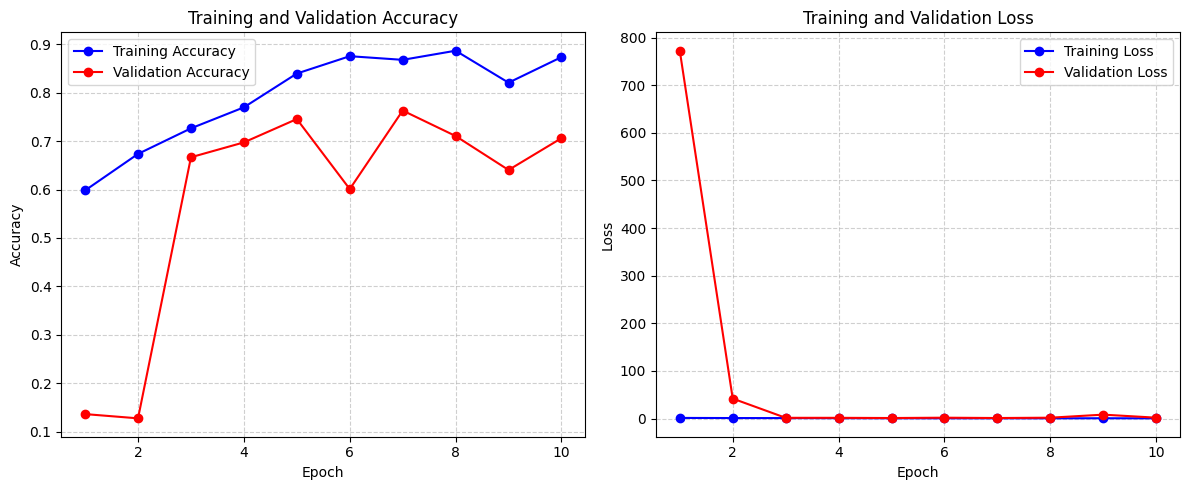

In [10]:
plot_history(history)